In [73]:
import pandas as pd
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re
import shutil
import string
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU

from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.preprocessing import  LabelEncoder
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

import pathlib 
import pandas as pd 
import plotly.express as px
import os
import io
import warnings
warnings.filterwarnings('ignore')

# EDA & initial preprocessings

In [2]:
df = pd.read_csv('https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv', encoding='latin-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
print("Percentage of missing values: ")
display(100 * df.isnull().sum() / df.shape[0])

Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [5]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

The last 3 columns contain more than 99% missing values, we can exclude them. The first column 'v1' has 2 possible values, spam or no spam (ham) and the second 'v2' corresponds to the texts received by users that are to be categorized either as spam or ham.

In [6]:
dataset = df.iloc[:,:2]

In [7]:
dataset.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
dataset['v2'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [9]:
dataset.shape

(5572, 2)

In [10]:
dataset['v1'].value_counts().values

array([4825,  747], dtype=int64)

In [11]:
dataset['v1'].value_counts().index

Index(['ham', 'spam'], dtype='object')

In [12]:
fig_target =  px.pie(dataset, values= dataset['v1'].value_counts().values, names=dataset['v1'].value_counts().index, title = 'Spam proportion', width = 500, height = 400)
fig_target.update(layout=dict(title=dict(x=0.5)))
fig_target.show()

# Preprocessings for nlp : 

In [13]:
#!pip install spacy

In [14]:
#!python -m spacy download fr_core_news_sm

## Eliminating non alphanumeric caracters, Lemmatization & Tokenization

In [15]:
import fr_core_news_sm
nlp = fr_core_news_sm.load()

In [16]:
from spacy.lang.fr.stop_words import STOP_WORDS

In [17]:
dataset["txt_clean"] = dataset["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
dataset["txt_clean"] = dataset["txt_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
dataset["txt_clean"] = dataset["txt_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [18]:
dataset.head()

,v1,v2,txt_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy availabl only in b...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 wkly comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah don' t think he goe to usf h live around h...


In [19]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(dataset.txt_clean)
dataset["txt_encoded"] = tokenizer.texts_to_sequences(dataset.txt_clean)

In [20]:
dataset.head()

,v1,v2,txt_clean,txt_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy availabl only in b...,"[42, 448, 1, 417, 692, 693, 63, 7, 1, 104, 115..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[45, 316, 1, 389, 5, 1]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 wkly comp to win fa cup final ...,"[47, 464, 7, 18, 732, 874, 2, 170, 1, 1, 612, ..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[5, 230, 118, 20, 365, 1, 5, 145, 142, 59, 118]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah don' t think he goe to usf h live around h...,"[925, 89, 28, 91, 66, 480, 2, 875, 1, 255, 202..."


## Creating a target column that will take value = 1 if spam, 0 otherwise

In [21]:
dataset['target'] = 0
dataset.loc[dataset['v1'] == 'spam',['target']] = 1

In [22]:
dataset['target'].value_counts()

0    4825
1     747
Name: target, dtype: int64

## Creation of a weights dictionnary 

Since the values are imbalanced (there are a lot more hams than spams), we create a weights dictionnary that will be imputed during the model fit so that the models takes into account this unbalance

In [23]:
spam_dict = dataset['target'].value_counts().to_dict()

In [24]:
spam_dict

{0: 4825, 1: 747}

In [25]:
target_dict = {}
for i, el in spam_dict.items():
  el = 1 / (el / dataset['target'].value_counts().sum()) / 5
  col = {i: el}
  target_dict.update(col)

In [26]:
target_dict

{0: 0.23096373056994818, 1: 1.491834002677376}

In [27]:
dataset.head()

,v1,v2,txt_clean,txt_encoded,target
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy availabl only in b...,"[42, 448, 1, 417, 692, 693, 63, 7, 1, 104, 115...",0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[45, 316, 1, 389, 5, 1]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 wkly comp to win fa cup final ...,"[47, 464, 7, 18, 732, 874, 2, 170, 1, 1, 612, ...",1
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[5, 230, 118, 20, 365, 1, 5, 145, 142, 59, 118]",0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah don' t think he goe to usf h live around h...,"[925, 89, 28, 91, 66, 480, 2, 875, 1, 255, 202...",0


## Padding

In [28]:
txt_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset["txt_encoded"], padding="post")

## Train test split

In [29]:
xtrain, xval, ytrain, yval = train_test_split(txt_pad, dataset['target'], test_size=0.3)

## Creating batches & shuffling 

In [30]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [31]:
for txt, target in train_batch.take(1):
  print(txt, target)

tf.Tensor(
[[117   5 793 ...   0   0   0]
 [330 310  70 ...   0   0   0]
 [ 49  53 426 ...   0   0   0]
 ...
 [513 155   6 ...   0   0   0]
 [ 64   3   3 ...   0   0   0]
 [ 36  65   2 ...   0   0   0]], shape=(64, 164), dtype=int32) tf.Tensor(
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0], shape=(64,), dtype=int64)


# Model

In [32]:
embedding_dim=8

vocab_size = tokenizer.num_words # the number of words in the vocabulary
model = Sequential([
  Embedding(vocab_size+1, embedding_dim, input_shape=[txt.shape[1],], name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GlobalAveragePooling1D(), # this will pick the average for every word in the sentence
  # along each dimension of the representation space.
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 164, 8)            8008      
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


## Creating additionnal metrics that will be shown during the model fit

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [35]:
# compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = model.fit(train_batch, validation_data=val_batch, class_weight=target_dict, epochs=50, callbacks=[tensorboard_callback])

Epoch 1/50
61/61 [==============================] - 2s 9ms/step - loss: 0.2757 - acc: 0.2777 - f1_m: 0.3050 - precision_m: 0.2261 - recall_m: 0.9449 - val_loss: 0.6891 - val_acc: 0.9091 - val_f1_m: 0.5343 - val_precision_m: 0.7247 - val_recall_m: 0.4450
Epoch 2/50
61/61 [==============================] - 0s 4ms/step - loss: 0.2741 - acc: 0.9051 - f1_m: 0.5780 - precision_m: 0.7162 - recall_m: 0.6009 - val_loss: 0.6790 - val_acc: 0.9211 - val_f1_m: 0.6367 - val_precision_m: 0.8437 - val_recall_m: 0.5405
Epoch 3/50
61/61 [==============================] - 0s 4ms/step - loss: 0.2699 - acc: 0.8897 - f1_m: 0.5227 - precision_m: 0.7389 - recall_m: 0.5241 - val_loss: 0.6945 - val_acc: 0.3044 - val_f1_m: 0.2803 - val_precision_m: 0.1644 - val_recall_m: 1.0000
Epoch 4/50
61/61 [==============================] - 0s 4ms/step - loss: 0.2609 - acc: 0.8321 - f1_m: 0.6738 - precision_m: 0.5717 - recall_m: 0.9426 - val_loss: 0.6549 - val_acc: 0.9001 - val_f1_m: 0.6893 - val_precision_m: 0.5630 - val_r

## Visualisation of the model's performance

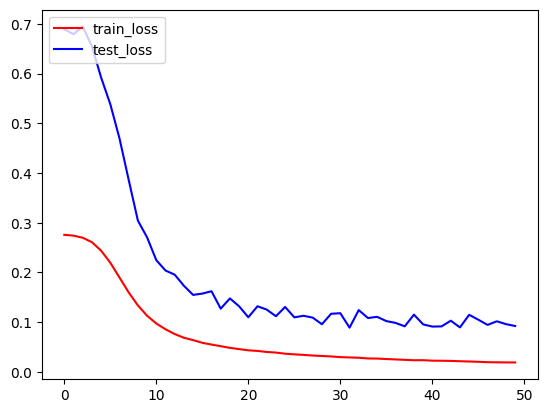

In [36]:
import matplotlib.pyplot as plt 
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [37]:
model.history.history.keys()

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m'])

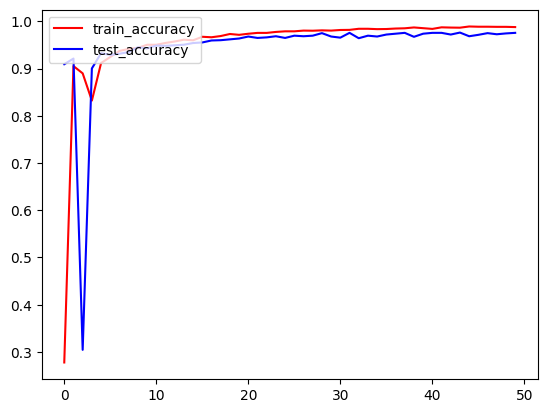

In [38]:
plt.plot(model.history.history["acc"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_acc"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

The model achieves a very impressive accuracy score in a very short time, over 95% in less then 5 epochs. In 50 epochs it achieves 98.1% accuracy.

Let's look at the f1 score :

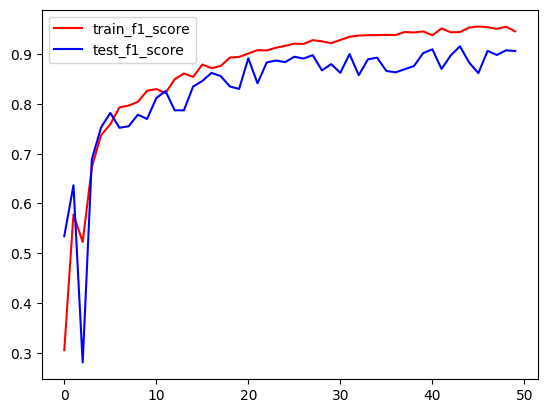

In [39]:
plt.plot(model.history.history["f1_m"], c="r", label="train_f1_score")
plt.plot(model.history.history["val_f1_m"], c="b", label="test_f1_score")
plt.legend(loc="upper left")
plt.show()

In [40]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(xval, yval, verbose=0)

In [41]:
print(f"f1_score: {f1_score}")
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")

f1_score: 0.8817960023880005
accuracy: 0.97547847032547
precision: 0.8756133317947388
recall: 0.9151161313056946


The f1 score rises above 90% for the train set, for the test set it oscillates between 87 and 91%

In [42]:
Y_train_pred = model.predict(xtrain)
Y_test_pred = model.predict(xval)
Y_train_pred = Y_train_pred.reshape(-1)
Y_test_pred = Y_test_pred.reshape(-1)
Y_train_pred= pd.DataFrame(Y_train_pred)
Y_test_pred= pd.DataFrame(Y_test_pred)
Y_train_pred = round(Y_train_pred)
Y_test_pred = round(Y_test_pred)

53/53 [==============================] - 0s 1ms/step


Confusion Matrix for the train set:


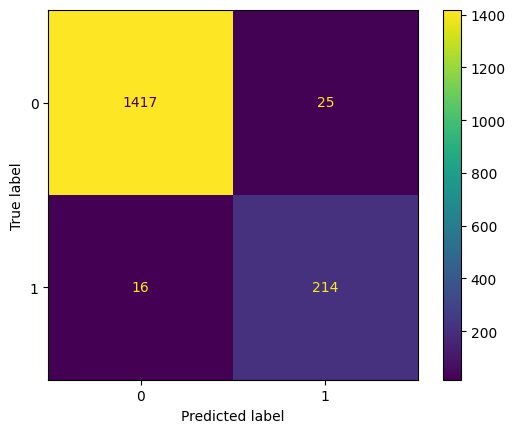

Confusion Matrix for the test set:


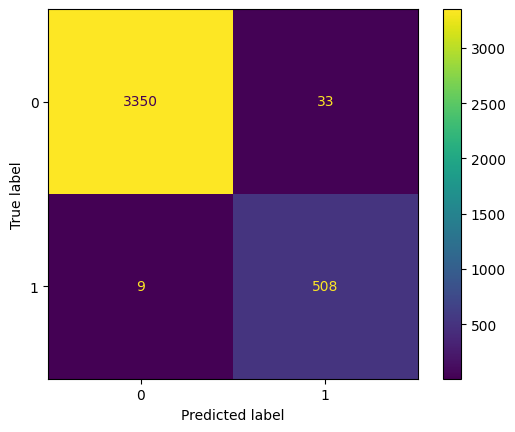

In [43]:
Confusion_matrix_train = confusion_matrix(yval,Y_test_pred)
ConfusionMatrixDisplay(Confusion_matrix_train).plot()
print('Confusion Matrix for the train set:')
plt.show()
Confusion_matrix_test = confusion_matrix(ytrain,Y_train_pred)
print('Confusion Matrix for the test set:')
ConfusionMatrixDisplay(Confusion_matrix_test).plot()
plt.show()

# Transfer learning

In [44]:
#!pip install transformers

In [45]:
#!pip install torch

In [46]:
dataset.head()

,v1,v2,txt_clean,txt_encoded,target
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy availabl only in b...,"[42, 448, 1, 417, 692, 693, 63, 7, 1, 104, 115...",0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[45, 316, 1, 389, 5, 1]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 wkly comp to win fa cup final ...,"[47, 464, 7, 18, 732, 874, 2, 170, 1, 1, 612, ...",1
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[5, 230, 118, 20, 365, 1, 5, 145, 142, 59, 118]",0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah don' t think he goe to usf h live around h...,"[925, 89, 28, 91, 66, 480, 2, 875, 1, 255, 202...",0


In [47]:
dataset['target'] = 0
dataset.loc[dataset['v1'] == 'spam',['target']] = 1

In [76]:
dataset["txt_clean"] = dataset["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
dataset["txt_clean"] = dataset["txt_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
xtrain, xval, ytrain, yval = train_test_split(dataset.txt_clean,dataset.target, test_size=0.2, stratify=dataset.target)
#ytrain = encoder.fit_transform(ytrain)
#yval = encoder.transform(yval)

In [84]:
encoder = LabelEncoder()
ytrain = encoder.fit_transform(ytrain)
yval = encoder.transform(yval)

In [85]:
yval

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [87]:
from array import array
res = array(yval)

TypeError: array() argument 1 must be a unicode character, not numpy.ndarray

In [83]:
res

array('i', [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0

In [49]:
tokenizer = AutoTokenizer.from_pretrained('mariagrandury/roberta-base-finetuned-sms-spam-detection')
model = TFAutoModelForSequenceClassification.from_pretrained('mariagrandury/roberta-base-finetuned-sms-spam-detection',from_pt=True)

encoded_input = tokenizer(list(xval), return_tensors='tf', padding = True)
output = model(encoded_input)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [53]:
test_predictions = []
for i in output[0]:
    test_predictions.append(np.argmax(i))

In [71]:
test_predictions

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [67]:
yval.value_counts()

0    966
1    149
Name: target, dtype: int64

In [68]:
print("accuracy on test set : ", accuracy_score(yval, test_predictions))
print("f1-score on test set : ", f1_score(yval, test_predictions))

accuracy on test set :  0.9910313901345291


TypeError: 'float' object is not callable

Our home made model already gives impressive results in a very limited training time; achieving over 98% accuracy and a f1_score of around 90% in only 50 epochs.
The chosen pretrained model unsurprisingly gives much better resultats with an accuracy of 99.7% and a f1_score of 99%.